In [1]:
# ------------------------------------------------------------------------------
# Authors: Andreas Nilsson, Anouka Ranby, Erik Rosvall (All part of ADS program)
# Date: 23 Jan 2022
# Description: Decision Trees - Applied Machine Learning, DIT867
# ------------------------------------------------------------------------------

### Task 3: A regression example: predicting apartment prices
The goal is to predict the price of an apartment, given numerical information such as the number of rooms, the size of the apartment in square meters, the floor, etc. Our approach will be similar to what we did in the classification example: load the data, find a suitable model using cross-validation over the training set, and finally evaluate on the held-out test data.


In [2]:
## Importing Libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.dummy import DummyRegressor
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier ,DecisionTreeRegressor # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier ,RandomForestRegressor
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score ,mean_squared_error
import os

Here is another dataset. This dataset was created by Sberbank and contains some statistics from the Russian real estate market. Here is the Kaggle page where you can find the original data.

Since we will just be able to handle numerical features and not symbolic ones, we'll need with a simplified version of the dataset. So we'll just select 9 of the columns in the dataset.

The following code snippet will carry out the basic reading and preprocessing of the data.

In [3]:
# Read the CSV file using Pandas.
alldata = pd.read_csv('sberbank.csv')

# Convert the timestamp string to an integer representing the year.
def get_year(timestamp):
    return int(timestamp[:4])
alldata['year'] = alldata.timestamp.apply(get_year)

# Select the 9 input columns and the output column.
selected_columns = ['price_doc', 'year', 'full_sq', 'life_sq', 'floor', 'num_room', 'kitch_sq', 'full_all']
alldata = alldata[selected_columns]
alldata = alldata.dropna()

# Shuffle.
alldata_shuffled = alldata.sample(frac=1.0, random_state=0)

# Separate the input and output columns.
X = alldata_shuffled.drop('price_doc', axis=1)
# For the output, we'll use the log of the sales price.
Y = alldata_shuffled['price_doc'].apply(np.log)

# Split into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

Then we train a baseline dummy regressor (which always predicts the same value) and evaluate it in a cross-validation setting.

This example looks quite similar to the classification example above. The main differences are (a) that we are predicting numerical values, not symbolic values; (b) that we are evaluating using the mean squared error metric, not the accuracy metric that we used to evaluate the classifiers.

In [4]:
# creating the dummy baseline regressor and cross validate 
m1 = DummyRegressor()
m1.fit(Xtrain,Ytrain)

cross_validate(m1, Xtrain, Ytrain, scoring='neg_mean_squared_error')

{'fit_time': array([0.00599098, 0.00404358, 0.00336051, 0.        , 0.00861406]),
 'score_time': array([0.00198698, 0.00058293, 0.        , 0.        , 0.        ]),
 'test_score': array([-0.39897319, -0.37113485, -0.38083108, -0.39057156, -0.40475168])}

Replace the dummy regressor with something more meaningful and iterate until you cannot improve the performance. Please note that the cross_validate function returns the negative mean squared error.

---
##### Comments: 
In the comming section we will test tree models against eachother. Initally they will be run without any modification and after we will tune the hyperparameters against each other, the competing models are:

 
1. Decision Tree Regression (DTR)
 
DTR models have the structure as a hierarchical tree that utilizes the input data to answer questions where the output is numerical. It can be thought of as a tree where each branch is split by a what if statement. It initiates by finding the most important feature and creates a rule that leads to more homenious datasets than the training set. When it finds that it recursively process to next level in the lower level and do the same logic. This leaves the tree structure with decision nodes and leaf nodes respectively. A node in this case can have two branches as a minimum, this node is a representation of the tested values. The leaf nodes represent the actual decision.
 
Modified Hyperparameters:
- max_depth: maximum depth of the tree.
- max_features: max features has three different ways to consider the best split (auto, sqrt, log2).
- min_samples_leaf: min samples leaf is the minimum amount of a sample to create a leaf node.
- random_state: random state is a random control that controls the randomly permuted split. It chooses either max_feature or n_feature, depending which of them are smallest. The best split is when these two parameters are equal to each other.


2. Gradient Boosting (GB)
 
GB uses the model with a forward stage-wise, by doing this the model can allow for optimization of the loss function which contains arbitrary differentiable.
 
Modified Hyperparameters:
- learning_rate: the learning rate is compressing the share for each tree.
- max_features: number of features to take into account when trying to find the best split of n_features. There are three different methods, but in the test we only used two of them, ['auto', 'sqrt'].
  - Auto: takes all of n features as a parameter
  - Sqrt: takes the square root of the n parameters aa the parameter
  - log2:
- max_depth: max depth limits the amount of nodes in the regression tree.
- min_samples_split: min samples split is the minimum amount of a sample to be splitted into a node.
- min_samples_leaf: min samples leaf is the minimum amount of a sample to create a leaf node.


3. Random Forest (RF)
 
RF works as an estimator to classify numbers that belong to the decision tree, which contains samples from the dataset that was provided. In other words it works as an ensemble model that splits the input features in a collection of trees. RF uses an averaging technique to make its predictions of accuracy and overfitting control. If the hyperparameter bootstrap is set to true it will perform bootstrapping on the input data but if set to false it utilizes all data to construct the tree.
 
Modified Hyperparameters:
- max_depth: maximum depth of the tree.
- min_samples_split: min samples split is the minimum amount of a sample to be splitted into a node.
- min_samples_leaf: min samples leaf is teh minimum amount of a sample to create a leaf node.
- max_features: max features has three different ways to consider the best split.

In [5]:
# Create Gradient Boosting Classifier object, train and cross validate
bgc = GradientBoostingRegressor()
bgc.fit(Xtrain,Ytrain)
CVS_GB = cross_val_score(bgc, Xtrain, Ytrain, scoring='neg_mean_squared_error')

# Create Random Forest Classifier object, train and cross validate
rfr = RandomForestRegressor(n_estimators = 100, random_state = 42)
rfr.fit(Xtrain,Ytrain)
CVS_RF = cross_val_score(rfr, Xtrain, Ytrain, scoring='neg_mean_squared_error')

# Create Decision Tree classifer object, train and cross validate
dtc = DecisionTreeRegressor()
dtc.fit(Xtrain,Ytrain)
CVS_DT = cross_val_score(dtc, Xtrain, Ytrain , scoring='neg_mean_squared_error')

In [6]:
## This part is just to merge model results nicely so it can be plotted in the plotting function bellow
lengthCross = list(range(1,len(CVS_DT)+1))

d = pd.DataFrame(CVS_DT)
d['Model'] = 'DecisionTreeRegression'
d['CrossValidation'] = lengthCross

d1 = pd.DataFrame(CVS_RF)
d1['Model'] = 'RandomForestRegression'
d1['CrossValidation'] = lengthCross

d2 = pd.DataFrame(CVS_GB)
d2['Model'] = 'GradientBoostingRegression'
d2['CrossValidation'] = lengthCross

## Merge datadrames
frame = d.append(d1)
frame = frame.append(d2)

frame.columns = ['neg_mean_squared_error', 'Model','CrossValidation']
#frame.head(7)

In [7]:
# function to plot tree
def plotlines(data):
    ## Reset Index to plot
    frame.reset_index(inplace=True)

    sns.set_theme(style="whitegrid")

    sns.set_context("talk", font_scale=1.1)
    plt.figure(figsize=(10,6))
    sns.lineplot(x="CrossValidation", 
                    y="neg_mean_squared_error",
                    hue="Model",
                    data=frame)
    # Put the legend out of the figure
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
    plt.title("Model Performance")
    plt.tight_layout()
    plt.gcf().set_size_inches((24, 6)) 

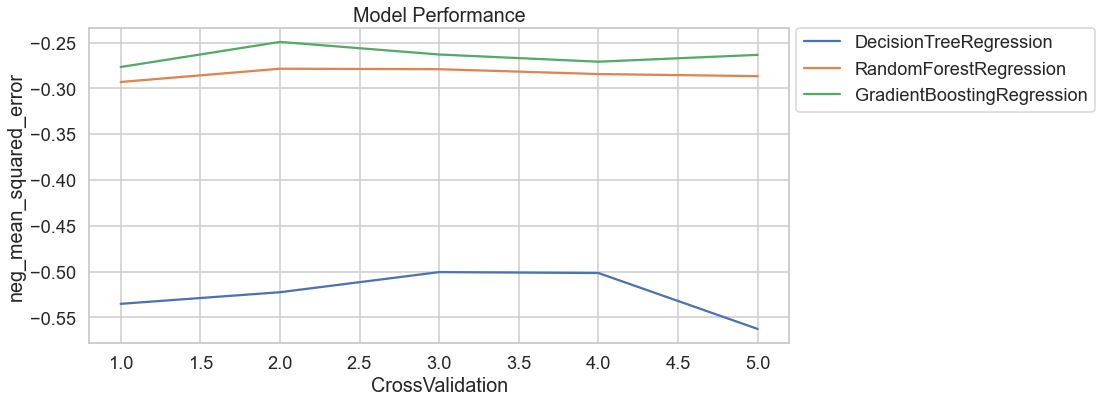

In [8]:
plotlines(frame)

##### Comments: 
The results show the negative mean squared error evaluation metric on the y-axis and the different folds from the cross validation on the x-axis. We see from our competing models that the GradientBoosting model is the one with the best performance among the models for all the tests in the cross validation. The Randomforest model is not far away while the decision tree is lacking behind.

Lets see if we can tune them to change these results!

##### Tunning Hyperparameters - DecisionTreeRegression

Bellow we will start to see if we can increase the performance of the Decsisson tree then continue to the other models

In [21]:
dt=DecisionTreeRegressor()

## specify grid
parameter_grid = {'max_depth': [1, 2, 3, 4, 5], 
                  'max_features': [1, 2, 3, 4, 5],
                 'random_state':[0, 1, 2, 3, 4, 5],
                  "min_samples_leaf": np.linspace(0.001, 0.03, 5)
                 }


## Run the grid
grid_search = GridSearchCV(dt, param_grid = parameter_grid,cv =3)
grid_search.fit(Xtrain, Ytrain)

print ("Best Score: {}".format(grid_search.best_score_))
print ("Best params: {}".format(grid_search.best_params_))

Best Score: 0.26940962736485485
Best params: {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 0.001, 'random_state': 1}


In [22]:
# Create Decision Tree regression object non tuned
dtc = DecisionTreeRegressor()
# train model
dtc.fit(Xtrain,Ytrain)
# cross validate
CVS_DT = cross_val_score(dtc, Xtrain, Ytrain , scoring='neg_mean_squared_error' )

# Create Decision Tree Regression object tuned
dtc_tuned = DecisionTreeRegressor(max_depth = 5 ,   # 20
                             max_features = 5,
                             min_samples_leaf = 0.001,
                             random_state = 1
                             )

# train
dtc_tuned.fit(Xtrain,Ytrain)  
# cross validate
CVS_DT_Tuned = cross_val_score(dtc_tuned, Xtrain, Ytrain , scoring='neg_mean_squared_error' )

In [23]:
def structureHyperData(notTuned,isTuned):
    """ Function to structure data before plotting results"""

    lengthCross = list(range(1,len(CVS_DT)+1))
    
    d = pd.DataFrame(notTuned)
    d['Model'] = 'Not Tuned Model'
    d['CrossValidation'] = lengthCross

    d2 = pd.DataFrame(isTuned)
    d2['Model'] = 'Tuned Model'
    d2['CrossValidation'] = lengthCross

    ## Merge datadrames
    frame = d.append(d2)
    frame.columns = ['neg_mean_squared_error', 'Model','CrossValidation']
    
    print('Average Non - Tunned Model: ' + str(round(np.mean(notTuned),3)))
    print('Average Tunned Model: ' + str(round(np.mean(isTuned),3)))

    return frame

Average Non - Tunned Model: -0.523
Average Tunned Model: -0.283


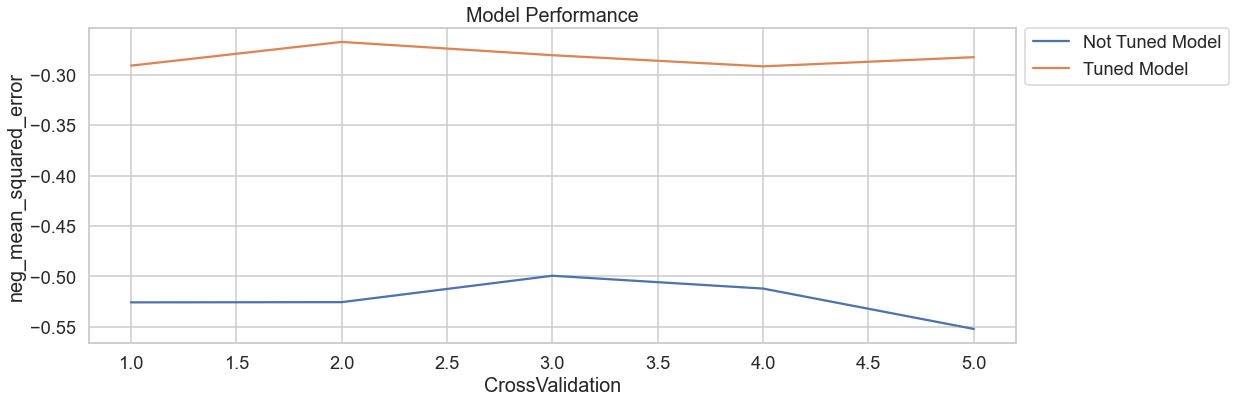

In [24]:
## plot results to see how we did
frame = structureHyperData(CVS_DT,CVS_DT_Tuned)
plotlines(frame)

##### Comments: DTR

Here the tunning made wonders in realtion to the non tuned Decision Tree with resulting NMSE at -0.28.

##### Tunning Hyperparameters - GradientBoosting

In [25]:
## specify grid
parameters = {
    "learning_rate": [0.25, 0.3, 0.35, 0.4, 0.5], 
    "min_samples_split": np.linspace(0.001, 0.5, 10),
    "min_samples_leaf": np.linspace(0.001, 0.03, 5),
    "max_depth":[ 1, 2, 3, 4, 5,6,7,8,9,10], 
    "max_features":["log2","sqrt",'auto'], 
    "criterion": ["friedman_mse",  "mse"],
    }

#passing the scoring function in the GridSearchCV
clf = GridSearchCV(GradientBoostingRegressor(), parameters,  refit=False,cv=2, n_jobs=-1) # scoring=scoring,
clf.fit(Xtrain, Ytrain)

print ("Best Score: {}".format(clf.best_score_))
print ("Best params: {}".format(clf.best_params_))

Best Score: 0.3356155586242405
Best params: {'criterion': 'friedman_mse', 'learning_rate': 0.3, 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 0.001, 'min_samples_split': 0.05644444444444444}


In [26]:
# Create Gradient Boosting Regression object non tuned
bgc = GradientBoostingRegressor()
# train model
bgc.fit(Xtrain,Ytrain)
# cross validate
CVS_GB_noTune = cross_val_score(bgc, Xtrain, Ytrain , scoring='neg_mean_squared_error')

# Create Gradient Boosting Regression object tuned
bgc_tuned = GradientBoostingRegressor(
                                criterion = 'friedman_mse',
                                 learning_rate = 0.35 ,
                                 max_depth = 4 ,
                                 max_features = 'auto',
                                 min_samples_leaf = 0.001,
                                min_samples_split = 0.001) 

# train model
bgc_tuned.fit(Xtrain,Ytrain)
# cross validate
CVS_GB_Tune = cross_val_score(bgc_tuned, Xtrain, Ytrain , scoring='neg_mean_squared_error')

Average Non - Tunned Model: -0.265
Average Tunned Model: -0.257


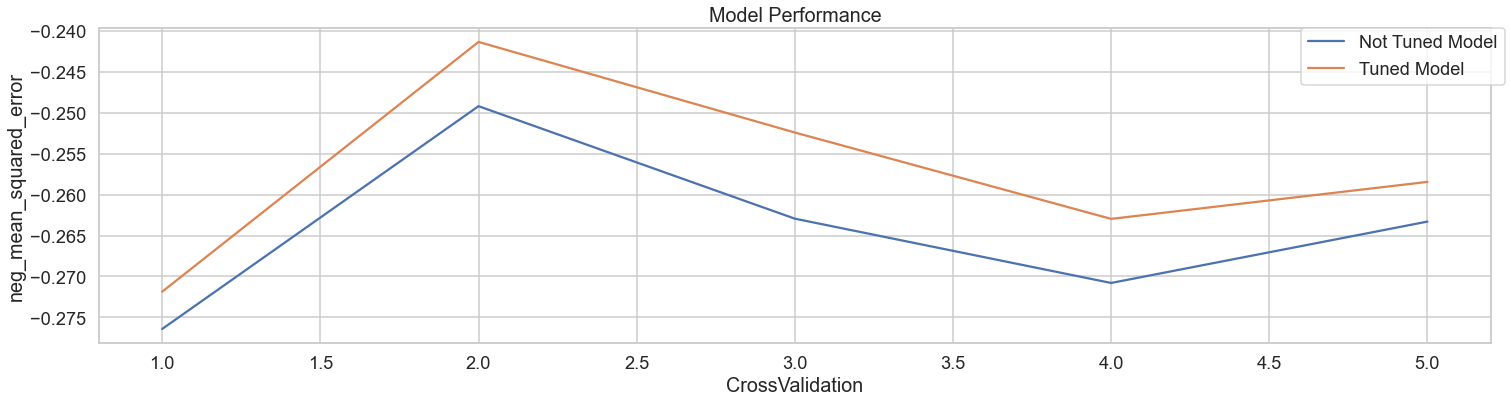

In [27]:
## plot results to see how we did
frame = structureHyperData(CVS_GB_noTune,CVS_GB_Tune)
plotlines(frame)

##### Comments: GBR
Even this time the tuning lead to a slight increased performance for the model. On average the performance was -0.25 for the tuned model, which is slightly better than the tune DTR.

##### Tunning Hyperparameters - RandomForest

In [28]:
# grid search
parameters = {
    'max_depth': [1, 2, 3, 4,5,6,7, 8,9,10,15,20,30,40,50],
     "min_samples_split": np.linspace(0.001, 0.5, 10),
     "min_samples_leaf": np.linspace(0.001, 0.5, 10),
    "max_features":["log2","sqrt"],
    }

#passing the scoring function in the GridSearchCV
clf = GridSearchCV(RandomForestRegressor(), parameters,  refit=False,cv=2, n_jobs=-1) # scoring=scoring,
clf.fit(Xtrain, Ytrain)

print ("Best Score: {}".format(clf.best_score_))
print ("Best params: {}".format(clf.best_params_))

Best Score: 0.3047647513697478
Best params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 0.001, 'min_samples_split': 0.001}


In [29]:
# Create Random Forest Regression object not tuned
rfr = RandomForestRegressor(n_estimators = 100, random_state = 42) # 
# train model
rfr.fit(Xtrain,Ytrain)
# cross validate
CVS_RF = cross_val_score(rfr, Xtrain, Ytrain , scoring='neg_mean_squared_error')

# Create Random Forest Regression object tuned
rfr_tune = RandomForestRegressor(#criterion = 'entropy',
                                 max_depth = 40 ,
                                 max_features = 'log2',
                                 min_samples_leaf = 0.001,
                                 min_samples_split = 0.001
                                 ) 

# train model
rfr_tune.fit(Xtrain,Ytrain)
# cross validate
CVS_RF_Tuned = cross_val_score(bgc_tuned, Xtrain, Ytrain , scoring='neg_mean_squared_error')

Average Non - Tunned Model: -0.284
Average Tunned Model: -0.257


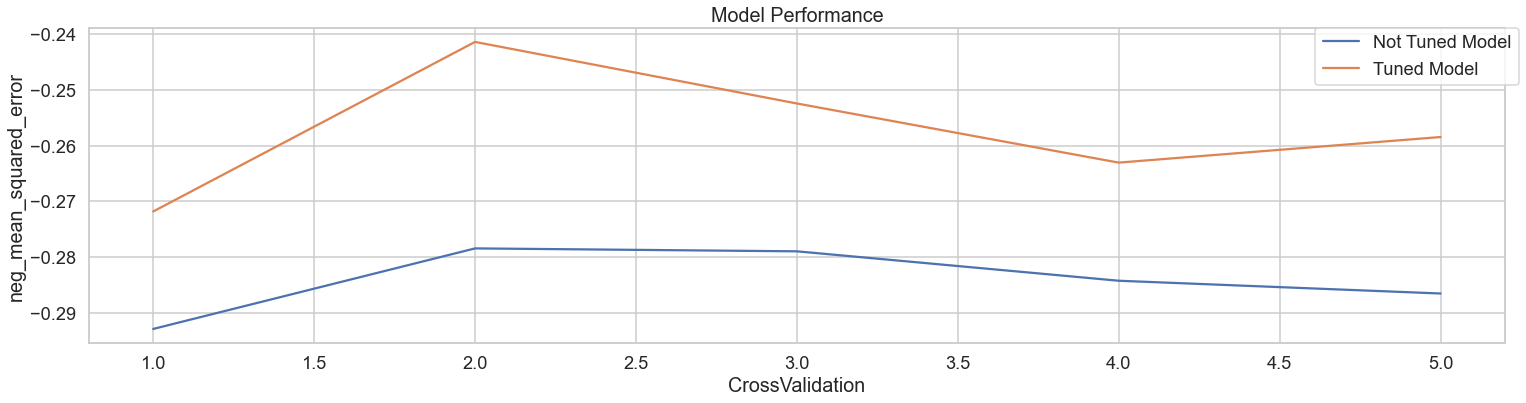

In [30]:
## plot results to see how we did
frame = structureHyperData(CVS_RF,CVS_RF_Tuned)
plotlines(frame)

##### Comments: RFR
We can also see here on the graph and form the average results printed above that there was a decreased in NMSE. The tuned Random forest model was better with average -0.25 NMSE, similar to the Gradient Boosting regressor.

##### Final evaluation

In [31]:
## Store and structure model results on test data
models = [dtc,dtc_tuned,bgc,bgc_tuned,rfr,rfr_tune]
Results = []

for i in models:
    i.fit(Xtrain, Ytrain)
    Yguess = i.predict(Xtest)
    Results.append(mean_squared_error(Ytest, Yguess))

ResultsFrame = pd.DataFrame(Results)
ResultsFrame['Model'] = ['DT','DT','GB','GB','RF','RF']
ResultsFrame['HyperParametertuned'] = ['N','Y','N','Y','N','Y']
ResultsFrame.columns = ['MSE', 'Model','HyperParametertuned']

(0.25, 0.6)

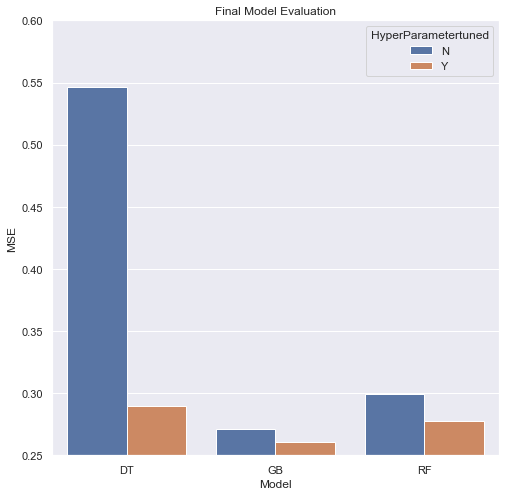

In [32]:
# set plot style: grey grid in the background:
sns.set(style="darkgrid")

# Set the figure size
plt.figure(figsize=(8, 8))

# grouped barplot
plt.title("Final Model Evaluation")
g = sns.barplot(x="Model", y="MSE", hue="HyperParametertuned", data=ResultsFrame, ci=0.9);
g.set_ylim(0.25, 0.6)

##### Comments:
After the hyperparametertuning on all three models these are the results achieved when running on the unseen test data.

As seen in the chart above the model with the lowest bars for both tuned (orange) and non-tuned (blue) was the Gradient Boost since it generated the lowest mean squared error for these models. As a result the winning model we will pick will be the tuned Gradient Boost model!

In general, all tuned (orange) versions of the models had a better performance on the test data compared to the non-tuned verison.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a6ba0eaf-97fa-4fd0-ab2f-858132e990c1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>